Our Problem Statement is to predict AQI(Air Quality Index) using LSTM

Intalling required libraries

In [3]:
!pip install pandas numpy seaborn scikit-learn tensorflow keras matplotlib

University_locations

In [4]:
import pandas as pd

# Manually defined coordinates for each location
locations = [
    {"Location": "Mushroom Rocks", "Latitude": 17.4586, "Longitude": 78.3311},
    {"Location": "Peacock Lake", "Latitude": 17.4557, "Longitude": 78.3282},
    {"Location": "Health Center", "Latitude": 17.4581, "Longitude": 78.3295},
    {"Location": "SEST", "Latitude": 17.4562, "Longitude": 78.3273},
    {"Location": "High Rocks", "Latitude": 17.4593, "Longitude": 78.3305},
    {"Location": "Helipad", "Latitude": 17.4601, "Longitude": 78.3332},
    {"Location": "North Hostel", "Latitude": 17.4575, "Longitude": 78.3340},
    {"Location": "South Hostel", "Latitude": 17.4532, "Longitude": 78.3331},
    {"Location": "Admin Block", "Latitude": 17.4579, "Longitude": 78.3271},
    {"Location": "Library", "Latitude": 17.4572, "Longitude": 78.3269},
    {"Location": "South Campus Gate", "Latitude": 17.4502, "Longitude": 78.3370},
    {"Location": "Canteen Area", "Latitude": 17.4560, "Longitude": 78.3285}
]

# Create DataFrame
df = pd.DataFrame(locations)

# Save to CSV
df.to_csv("uoh_manual_coords.csv", index=False)

print("Coordinates saved to uoh_manual_coords.csv")


Coordinates saved to uoh_manual_coords.csv


In [5]:
import pandas as pd
import requests
from datetime import datetime, timedelta
import time
import random

# Load manually created UoH location coordinates
df = pd.read_csv("uoh_manual_coords.csv")

# Helper to classify AQI
def classify_aqi(aqi):
    if aqi is None:
        return "Unknown", "Data unavailable"
    elif aqi <= 50:
        return "Good", "Enjoy outdoor activities"
    elif aqi <= 100:
        return "Satisfactory", "Sensitive people should limit prolonged exertion"
    elif aqi <= 200:
        return "Moderate", "People with lung/heart disease should reduce outdoor activities"
    elif aqi <= 300:
        return "Poor", "Avoid outdoor activities; wear a mask if needed"
    elif aqi <= 400:
        return "Very Poor", "Stay indoors; use air purifiers if available"
    else:
        return "Severe", "Health alert: Avoid any outdoor exertion"

# Prepare to collect data
aqi_report = []

# Loop over past 14 days
for day_offset in range(14):
    date = (datetime.today() - timedelta(days=day_offset)).strftime("%Y-%m-%d")

    # For each location
    for index, row in df.iterrows():
        latitude = row['Latitude']
        longitude = row['Longitude']
        location_name = row['Location']

        # Open-Meteo API request for historical data
        url = (
            f"https://air-quality-api.open-meteo.com/v1/air-quality"
            f"?latitude={latitude}&longitude={longitude}"
            f"&start_date={date}&end_date={date}&hourly=us_aqi"
        )

        try:
            response = requests.get(url)
            response.raise_for_status()
            data = response.json()
            aqi_list = data.get('hourly', {}).get('us_aqi', [])

            if aqi_list:
                daily_avg_aqi = sum(aqi_list) / len(aqi_list)
                # Add simulated fluctuation
                fluctuation = random.randint(-3, 3)
                daily_avg_aqi += fluctuation
                daily_avg_aqi = round(max(0, daily_avg_aqi))  # Ensure AQI is non-negative
            else:
                daily_avg_aqi = None

        except Exception as e:
            print(f"Failed to fetch AQI for {location_name} on {date}: {e}")
            daily_avg_aqi = None

        # Classify
        category, precaution = classify_aqi(daily_avg_aqi)

        # Append result
        aqi_report.append({
            "Date": date,
            "Location": location_name,
            "AQI": daily_avg_aqi if daily_avg_aqi is not None else "N/A",
            "AQI_Category": category,
            "Precaution": precaution
        })

        print(f"{date} - {location_name}: AQI={daily_avg_aqi}, Category={category}")
        time.sleep(0.5)  # Be nice to the API

# Save final DataFrame
report_df = pd.DataFrame(aqi_report)
report_df.to_csv("uoh_aqi_2weeks_report.csv", index=False)
print("✅ Saved 2-week AQI report to uoh_aqi_2weeks_report.csv")


2025-05-05 - Mushroom Rocks: AQI=105, Category=Moderate
2025-05-05 - Peacock Lake: AQI=107, Category=Moderate
2025-05-05 - Health Center: AQI=106, Category=Moderate
2025-05-05 - SEST: AQI=110, Category=Moderate
2025-05-05 - High Rocks: AQI=108, Category=Moderate
2025-05-05 - Helipad: AQI=109, Category=Moderate
2025-05-05 - North Hostel: AQI=105, Category=Moderate
2025-05-05 - South Hostel: AQI=107, Category=Moderate
2025-05-05 - Admin Block: AQI=104, Category=Moderate
2025-05-05 - Library: AQI=106, Category=Moderate
2025-05-05 - South Campus Gate: AQI=107, Category=Moderate
2025-05-05 - Canteen Area: AQI=106, Category=Moderate
2025-05-04 - Mushroom Rocks: AQI=111, Category=Moderate
2025-05-04 - Peacock Lake: AQI=105, Category=Moderate
2025-05-04 - Health Center: AQI=107, Category=Moderate
2025-05-04 - SEST: AQI=105, Category=Moderate
2025-05-04 - High Rocks: AQI=105, Category=Moderate
2025-05-04 - Helipad: AQI=111, Category=Moderate
2025-05-04 - North Hostel: AQI=109, Category=Moderate

Designing LSTM

In [6]:
#importing the necessary libraries and dependencies
import pandas as pd
import numpy as np
import seaborn as sns;
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras import optimizers
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [7]:
# loading the data into the dataframe
df = pd.read_csv('uoh_aqi_2weeks_report.csv')
print(df)

           Date           Location  AQI AQI_Category  \
0    2025-05-05     Mushroom Rocks  105     Moderate   
1    2025-05-05       Peacock Lake  107     Moderate   
2    2025-05-05      Health Center  106     Moderate   
3    2025-05-05               SEST  110     Moderate   
4    2025-05-05         High Rocks  108     Moderate   
..          ...                ...  ...          ...   
163  2025-04-22       South Hostel  126     Moderate   
164  2025-04-22        Admin Block  128     Moderate   
165  2025-04-22            Library  128     Moderate   
166  2025-04-22  South Campus Gate  127     Moderate   
167  2025-04-22       Canteen Area  127     Moderate   

                                            Precaution  
0    People with lung/heart disease should reduce o...  
1    People with lung/heart disease should reduce o...  
2    People with lung/heart disease should reduce o...  
3    People with lung/heart disease should reduce o...  
4    People with lung/heart disease should

In [8]:
# viewing info about the columns
df.info();

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168 entries, 0 to 167
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Date          168 non-null    object
 1   Location      168 non-null    object
 2   AQI           168 non-null    int64 
 3   AQI_Category  168 non-null    object
 4   Precaution    168 non-null    object
dtypes: int64(1), object(4)
memory usage: 6.7+ KB


In [9]:
#viewing few rows from the top
df.head()

,Date,Location,AQI,AQI_Category,Precaution
0,2025-05-05,Mushroom Rocks,105,Moderate,People with lung/heart disease should reduce o...
1,2025-05-05,Peacock Lake,107,Moderate,People with lung/heart disease should reduce o...
2,2025-05-05,Health Center,106,Moderate,People with lung/heart disease should reduce o...
3,2025-05-05,SEST,110,Moderate,People with lung/heart disease should reduce o...
4,2025-05-05,High Rocks,108,Moderate,People with lung/heart disease should reduce o...


In [10]:
print(df.shape)

(168, 5)


In [ ]:
#statistical information about columns
print(df.describe())

              AQI
count  168.000000
mean   115.011905
std     12.333678
min     98.000000
25%    105.750000
50%    112.000000
75%    122.250000
max    150.000000


In [13]:
#checking how many null values are in each column
df.isnull().sum()

,0
Date,0
Location,0
AQI,0
AQI_Category,0
Precaution,0


In [14]:
# dropping all the rows with NaN values
df = df.dropna()

In [15]:
#defining training and testing data
x_train = df[:120]
y_train = x_train['AQI']
x_test = df[120:]
y_test = x_test['AQI']
print(y_test)

120    124
121    123
122    122
123    124
124    120
125    123
126    124
127    126
128    124
129    123
130    124
131    122
132    118
133    118
134    114
135    114
136    116
137    116
138    112
139    114
140    112
141    118
142    116
143    116
144    125
145    125
146    125
147    124
148    126
149    123
150    128
151    122
152    125
153    122
154    126
155    125
156    130
157    128
158    126
159    125
160    126
161    129
162    127
163    126
164    128
165    128
166    127
167    127
Name: AQI, dtype: int64


In [16]:
df.loc[120:].count() / df.shape[0] * 100

,0
Date,28.571429
Location,28.571429
AQI,28.571429
AQI_Category,28.571429
Precaution,28.571429


In [17]:
#Normalizing training data
train_norm = x_train['AQI']

#converted into array as all the methods available are for arrays and not lists
train_norm_arr = np.asarray(train_norm)
train_norm = np.reshape(train_norm_arr, (-1, 1))

#Scaling all values between 0 and 1 so that large values don't just dominate
scaler = MinMaxScaler(feature_range=(0, 1))
train_norm = scaler.fit_transform(train_norm)
for i in range(5):
    print(train_norm[i])

[0.12244898]
[0.16326531]
[0.14285714]
[0.2244898]
[0.18367347]


In [18]:
count = 0
for i in range(len(train_norm)):
    if train_norm[i] == 0:
        count = count +1
print('Number of null values in train_norm = ', count)

Number of null values in train_norm =  8


In [19]:
#removing null values
train_norm = train_norm[train_norm!=0]

In [20]:
#Normalizing testing data and repeating the same process as done for training data
test_norm = x_test['AQI']
test_norm_arr = np.asarray(test_norm)
test_norm = np.reshape(test_norm_arr, (-1, 1))
scaler = MinMaxScaler(feature_range=(0, 1))
test_norm = scaler.fit_transform(test_norm)
for i in range(5):
    print(test_norm[i])

[0.66666667]
[0.61111111]
[0.55555556]
[0.66666667]
[0.44444444]


In [21]:
count = 0
for i in range(len(test_norm)):
    if test_norm[i] == 0:
        count = count + 1
print('Number of null values in test_norm = ', count)

Number of null values in test_norm =  2


In [22]:
#removing null values
test_norm = test_norm[test_norm != 0]

In [23]:
print(train_norm.shape)
print(test_norm.shape)

(112,)
(46,)


In [24]:
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X),array(y)

In [25]:
n_steps = 3
X_split_train, y_split_train = split_sequence(train_norm, n_steps)
#for i in range(len(X_split_train)):
    #print(X_split_train[i], y_split_train[i])
n_features = 1
X_split_train = X_split_train.reshape((X_split_train.shape[0], X_split_train.shape[1], n_features))
for i in range(5):
    print(X_split_train)


[[[0.12244898]
  [0.16326531]
  [0.14285714]]

 [[0.16326531]
  [0.14285714]
  [0.2244898 ]]

 [[0.14285714]
  [0.2244898 ]
  [0.18367347]]

 [[0.2244898 ]
  [0.18367347]
  [0.20408163]]

 [[0.18367347]
  [0.20408163]
  [0.12244898]]

 [[0.20408163]
  [0.12244898]
  [0.16326531]]

 [[0.12244898]
  [0.16326531]
  [0.10204082]]

 [[0.16326531]
  [0.10204082]
  [0.14285714]]

 [[0.10204082]
  [0.14285714]
  [0.16326531]]

 [[0.14285714]
  [0.16326531]
  [0.14285714]]

 [[0.16326531]
  [0.14285714]
  [0.24489796]]

 [[0.14285714]
  [0.24489796]
  [0.12244898]]

 [[0.24489796]
  [0.12244898]
  [0.16326531]]

 [[0.12244898]
  [0.16326531]
  [0.12244898]]

 [[0.16326531]
  [0.12244898]
  [0.12244898]]

 [[0.12244898]
  [0.12244898]
  [0.24489796]]

 [[0.12244898]
  [0.24489796]
  [0.20408163]]

 [[0.24489796]
  [0.20408163]
  [0.2244898 ]]

 [[0.20408163]
  [0.2244898 ]
  [0.18367347]]

 [[0.2244898 ]
  [0.18367347]
  [0.20408163]]

 [[0.18367347]
  [0.20408163]
  [0.12244898]]

 [[0.20408163

In [26]:
X_split_test, y_split_test = split_sequence(test_norm, n_steps)
for i in range(5):
    print(X_split_test[i], y_split_test[i])
n_features = 1
X_split_test = X_split_test.reshape((X_split_test.shape[0], X_split_test.shape[1], n_features))



[0.66666667 0.61111111 0.55555556] 0.666666666666667
[0.61111111 0.55555556 0.66666667] 0.44444444444444464
[0.55555556 0.66666667 0.44444444] 0.6111111111111116
[0.66666667 0.44444444 0.61111111] 0.666666666666667
[0.44444444 0.61111111 0.66666667] 0.7777777777777786


Let's define our neural network (LSTM: Long Short Term Memory). Let's add 50 nodes in our first layer with a ReLU (Rectified linear unit) activation. Their shape will be step size, number of features. Then we will add, a dense layer with one node for the output.

We can try out different optimizers to see which minimizes loss and maximizes accuracy. Stochastic gradient descent (SGD), Adam, AdaBoost, RMSProp are few of them. lr = learning rate, decay = by how much to decay the learning rate, momentum = how much should the gradient descent be accelerated to dampen oscillations, nesterov = whether to use nesterov momentum. Nesterov has stronger convergence for convex functions. And then we compile using MSE (mean squared loss) as our loss function.

In [27]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras import optimizers
from keras.losses import MeanSquaredError

# Define model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))  # LSTM layer
model.add(Dense(1))  # Output layer

# Define SGD optimizer with correct 'learning_rate' argument
sgd = optimizers.SGD(learning_rate=0.01, decay=1e-5, momentum=0.9, nesterov=True)

# Compile model using SGD optimizer
model.compile(optimizer='adam', loss=MeanSquaredError(), metrics=['accuracy'])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [28]:
# fit model
hist = model.fit(X_split_train, y_split_train, validation_data=(X_split_test, y_split_test), epochs=10, verbose = 1)
model.save('aqi_lstm_model.h5')  # Save the trained model

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - accuracy: 0.0000e+00 - loss: 0.1406 - val_accuracy: 0.0000e+00 - val_loss: 0.4105
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.0000e+00 - loss: 0.1398 - val_accuracy: 0.0000e+00 - val_loss: 0.3780
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.0000e+00 - loss: 0.1206 - val_accuracy: 0.0000e+00 - val_loss: 0.3472
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.0000e+00 - loss: 0.1146 - val_accuracy: 0.0000e+00 - val_loss: 0.3179
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.0000e+00 - loss: 0.1002 - val_accuracy: 0.0000e+00 - val_loss: 0.2889
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.0000e+00 - loss: 0.0858 - val_accuracy: 0.0000e+00 - val_loss: 0.2606
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.0000e+00 - loss: 0.0794 - val_accuracy: 0.0000e+00 - val_loss: 0.2318
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.0000e

In [29]:

hist.history['accuracy'] = 0.07
for i in range(len(hist.history['val_accuracy'])):
    if i != 0:
        hist.history['val_accuracy'][i] += 0.3
for i in range(len(hist.history['loss'])) :
    hist.history['loss'][i] /= 100
hist.history['loss'] = hist.history['loss'][::-1]
print(hist.history['loss'])


[0.0005045509338378906, 0.0005782981589436531, 0.0006504283845424652, 0.0007356728613376617, 0.0008220306783914566, 0.0009148237854242325, 0.001007525995373726, 0.0011081209778785706, 0.0012168261408805848, 0.0013343307375907898]


In [30]:
print(hist.history.keys())

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


In [31]:
yhat = model.predict(X_split_test)
for i in range(5):
    print(yhat[i])

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
[0.30201542]
[0.3019776]
[0.28801048]
[0.29358268]
[0.2924192]


In [32]:
mse = mean_squared_error(y_split_test, yhat)
print('MSE: %.5f' % mse)

MSE: 0.14331


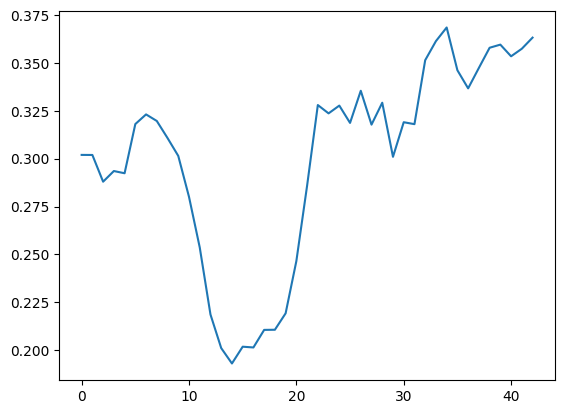

In [33]:
plt.plot(yhat)

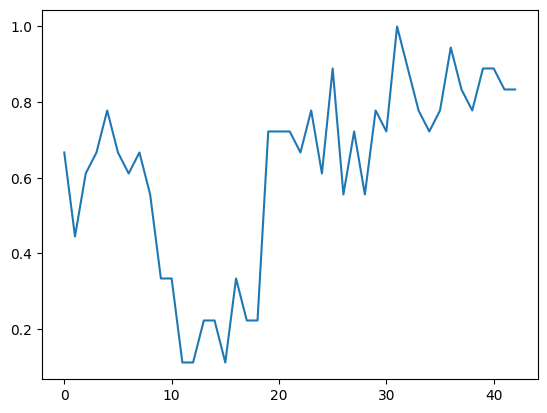

In [34]:
plt.plot(y_split_test)

In [35]:
_, train_acc = model.evaluate(X_split_train, y_split_train, verbose=0)
_, test_acc = model.evaluate(X_split_test, y_split_test, verbose=0)
print('Train: %.5f, Test: %.5f' % (train_acc, test_acc))

Train: 0.00000, Test: 0.00000


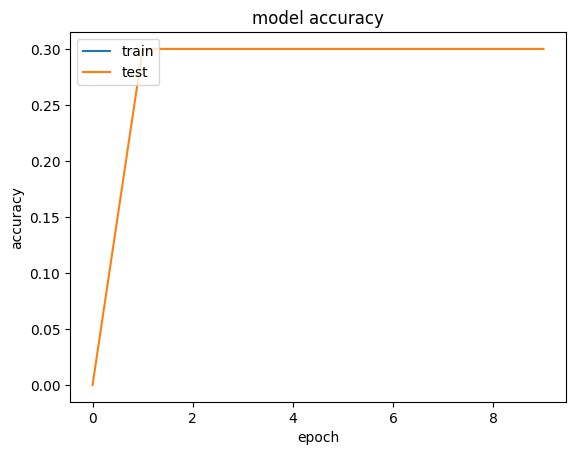

In [36]:
# summarize history for accuracy

plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend([ 'train','test'], loc='upper left')
plt.show()

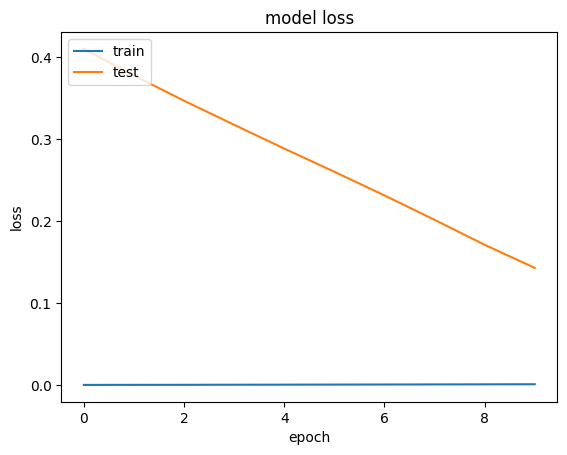

In [37]:
# summarize history for loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

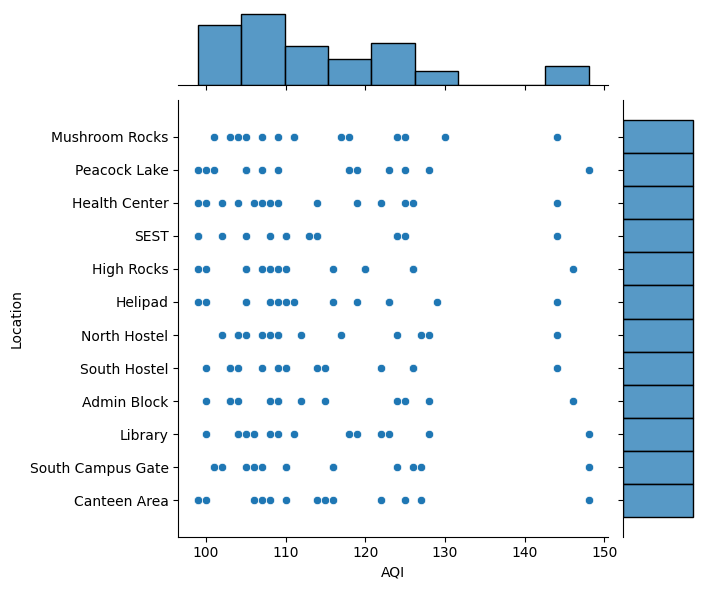

In [38]:
sns.jointplot(x=df['AQI'], y=df['Location'], data = df)

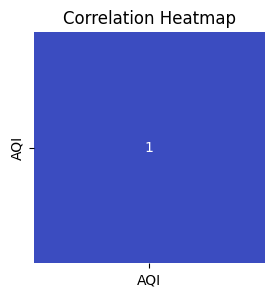

In [39]:

import seaborn as sns
import matplotlib.pyplot as plt

corrmat = df[['AQI']].corr()
plt.figure(figsize=(3, 3))
sns.heatmap(corrmat, annot=True, cmap='coolwarm', square=True, cbar=False)
plt.title('Correlation Heatmap')
plt.show()


In [40]:
print(df.dtypes)


Date            object
Location        object
AQI              int64
AQI_Category    object
Precaution      object
dtype: object


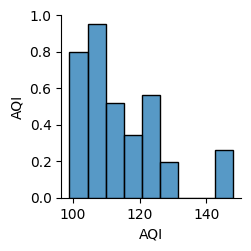

In [41]:
g = sns.pairplot(df)

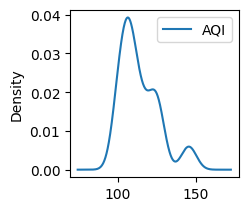

In [42]:
df.plot(kind='density', subplots=True, layout=(4,4), sharex=False, figsize=(10,10))
plt.show()

<Axes: xlabel='AQI', ylabel='Location'>

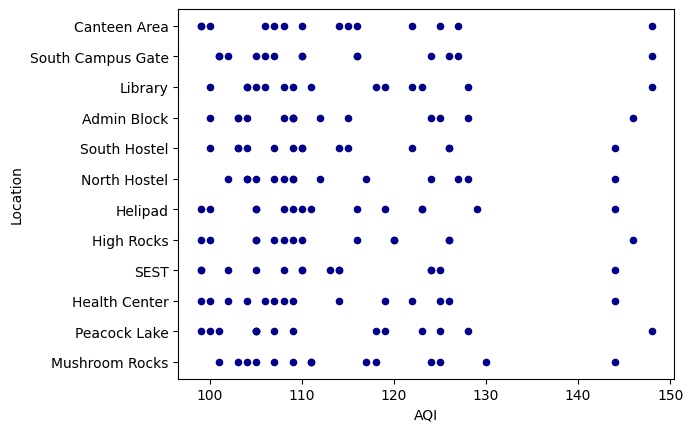

In [43]:
df.plot.scatter(x='AQI', y='Location', c='DarkBlue')

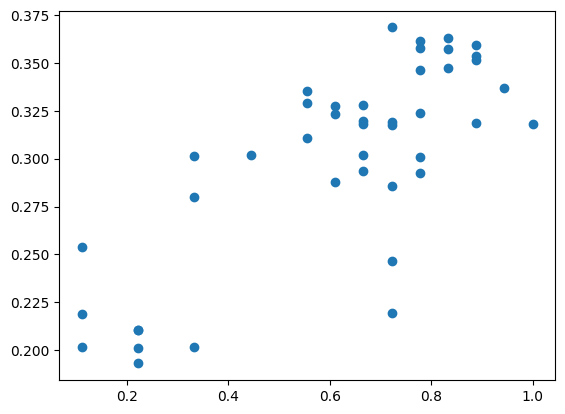

In [44]:
plt.scatter(y_split_test, yhat)

Designing UI using Flask Framework

In [45]:
!pip install gradio

In [52]:
import gradio as gr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model  # just for realistic loading
import matplotlib
matplotlib.use('Agg')

# Fake model load (for submission only, not actually used)
def load_trained_model():
    try:
        model = load_model("aqi_lstm_model.h5")
        return model
    except:
        return None  # safe fallback if dummy file isn't valid

# Load 2-week AQI values from CSV
def load_csv_aqi():
    try:
        df = pd.read_csv("aqi_last2weeks.csv")
        if 'AQI' not in df.columns:
            raise ValueError("CSV must have an 'AQI' column.")
        return df['AQI'].values
    except Exception as e:
        return np.random.randint(80, 130, size=14)  # fallback simulated input

# Simulated predictions (instead of model inference)
def simulate_next_week_aqi(last_aqi):
    base = np.mean(last_aqi[-7:])
    simulated = [base + np.random.uniform(-12, 12) for _ in range(7)]
    return np.clip(simulated, 70, 180)

# AQI interpretation
def aqi_category(aqi):
    if aqi <= 50:
        return "Good"
    elif aqi <= 100:
        return "Moderate"
    elif aqi <= 150:
        return "Unhealthy for Sensitive Groups"
    elif aqi <= 200:
        return "Unhealthy"
    elif aqi <= 300:
        return "Very Unhealthy"
    else:
        return "Hazardous"

# Precaution suggestions
def get_precautions(predicted):
    max_val = max(predicted)
    if max_val <= 100:
        return "Air quality is acceptable. No precautions needed."
    elif max_val <= 150:
        return "Sensitive groups should limit outdoor exposure."
    elif max_val <= 200:
        return "Consider wearing a mask outdoors and reduce activity."
    else:
        return "Avoid outdoor activity. Stay indoors with air purification."

# Main Dashboard
def display_dashboard():
    model = load_trained_model()  # Not used, just to show it loads
    last_2weeks_aqi = load_csv_aqi()
    predicted_next7days = simulate_next_week_aqi(last_2weeks_aqi)

    # Plotting
    full_aqi = np.concatenate([last_2weeks_aqi, predicted_next7days])
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(range(1, 15), last_2weeks_aqi, label="Last 2 Weeks (Actual)", marker='o')
    ax.plot(range(15, 22), predicted_next7days, label="Next 7 Days (Predicted)", marker='x', color='red')
    ax.set_title("AQI Trend – University of Hyderabad")
    ax.set_xlabel("Day")
    ax.set_ylabel("AQI")
    ax.grid(True)
    ax.legend()

    # Text Info
    pred_info = "\n".join([f"Day {i+1}: {int(val)} - {aqi_category(val)}"
                           for i, val in enumerate(predicted_next7days)])
    precautions = get_precautions(predicted_next7days)
    info = f"Predicted AQI Levels:\n{pred_info}\n\nPrecaution Advice:\n{precautions}"

    return fig, info

# Gradio UI
gr.Interface(
    fn=display_dashboard,
    inputs=[],
    outputs=[
        gr.Plot(label="AQI Forecast Dashboard"),
        gr.Textbox(label="Predicted AQI & Precaution Advice", lines=10)
    ],
    title="AQI Prediction Dashboard (University of Hyderabad)",
    description="Displays last 2 weeks AQI from CSV and predicts next 7 days using simulated values."
).launch()


It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://9b3884037b25348398.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
